#### orig sperr filter

On NCAR's Jupyterhub, environment NPL 2024b is a good option (Note: it contains an old version of ldcpy that does not support WRF data.  So make sure you have a recent version from https://github.com/NCAR/ldcpy.)


In [1]:
import os
import sys

import cf_xarray as cf
import xarray as xr
import xwrf

%load_ext autoreload
%autoreload 2
%matplotlib inline

# loading our own ldcpy repo
sys.path.insert(0, '/glade/u/home/abaker/repos/my_ldcpy')
# suppress all of the divide by zero warnings
import warnings

# sys.path.insert(0, '/../../../')
import ldcpy

warnings.filterwarnings("ignore")

In [2]:
# set as needed
casper = '/glade/work/abaker/compress-libs/casper_plugins'
os.environ['HDF5_PLUGIN_PATH'] = casper

In [3]:
# check
os.environ["HDF5_PLUGIN_PATH"]

'/glade/work/abaker/compress-libs/casper_plugins'

In [4]:
# (wrf2d_d01_2020-07-01_10:00:00  and then for 3d also)

# get the file names
mydir = "/glade/derecho/scratch/abaker/new_sperr_psnr100/"
file2d = "wrf2d_d01_2020-07-01_10:00:00"
file3d = "wrf3d_d01_2020-07-01_10:00:00"

# original data (lossless)
campdir = "/glade/campaign/cisl/asap/abaker/wrf/wrf_lulin/"
orig_file2d = campdir + file2d
orig_file3d = campdir + file3d

# look at new sperr file with psnr100
# can't use with old fileter
# sp_file2d = mydir  + file2d
# sp_file3d = mydir  + file3d

# for ref, previous sperr
# CAN'T USE THIS FILE WITH NEW FILTER
samdir = "/glade/campaign/cisl/asap/abaker/wrf/wrf_sam/sperr_psnr100/"
old_sp_file2d = samdir + file2d
old_sp_file3d = samdir + file3d

# this contains lat/lon info
fileconsts = campdir + "wrfconstants_usgs404.nc"

In [5]:
# file sizes? (optional to include in table when using collect datasets)
my_sizes_2d = []
my_sizes_3d = []
my_sizes_2d.append(os.path.getsize(orig_file2d))
my_sizes_3d.append(os.path.getsize(orig_file3d))

my_sp_sizes_2d = []
my_sp_sizes_3d = []

# my_sp_sizes_2d.append(os.path.getsize(sp_file2d))
my_sp_sizes_2d.append(os.path.getsize(old_sp_file2d))
# my_sp_sizes_3d.append(os.path.getsize(sp_file3d))
my_sp_sizes_3d.append(os.path.getsize(old_sp_file3d))

In [6]:
# file sizes
print(my_sizes_2d)
print(my_sp_sizes_2d)

print(my_sizes_3d)
print(my_sp_sizes_3d)

[423459547]
[198382378]
[1705618236]
[355040581]


In [7]:
# CR - compression ratios (Note: these are for the entire file, different variable may c compress with different ratios)
print("comparing to lossless!")
orig = my_sizes_2d[0]
sp_cr = []
for i in my_sp_sizes_2d:
    sp_cr.append(orig / i)
print("SPERR CR (2d): ", sp_cr)

orig = my_sizes_3d[0]
sp_cr = []
for i in my_sp_sizes_3d:
    sp_cr.append(orig / i)
print("SPERR CR (3d): ", sp_cr)

comparing to lossless!
SPERR CR (2d):  [2.134562309763219]
SPERR CR (3d):  [4.804009252114197]


In [8]:
# open all files as a dataset and process with xwrf for use with xarray
ds_orig_2d = xr.open_dataset(orig_file2d, engine="netcdf4").xwrf.postprocess()
ds_orig_3d = xr.open_dataset(orig_file3d, engine="netcdf4").xwrf.postprocess()

# ds_sp_2d = xr.open_dataset(sp_file2d, engine="netcdf4").xwrf.postprocess()
ds_old_sp_2d = xr.open_dataset(old_sp_file2d, engine="netcdf4").xwrf.postprocess()

# ds_sp_3d = xr.open_dataset(sp_file3d, engine="netcdf4").xwrf.postprocess()
ds_old_sp_3d = xr.open_dataset(old_sp_file3d, engine="netcdf4").xwrf.postprocess()

# coordinates
ds_const = xr.open_dataset(fileconsts, engine="netcdf4").xwrf.postprocess()

In [9]:
# make an ldcpy collection of all of this data to compare data (and pick a few variables to load).
# Passing in the file sizes is optional, but allows you to compare compression rates in the tables - here we are comparing
# to the ORIG size - the WHOLE file
combine_col_2d = ldcpy.collect_datasets(
    "wrf",
    ["T2", "U10", "Q2", "V10", "U", "V", "SNLIQ", "ACECAN", "RAINNCV", "LWUPT", "TV", "LAI"],
    [
        ds_orig_2d,
        ds_old_sp_2d,
    ],
    [
        "lossless",
        "old_sperr_psnr100",
    ],
    coords_ds=ds_const,
)

dataset size in GB 0.19



In [10]:
combine_col_3d = ldcpy.collect_datasets(
    "wrf",
    ["U", "V", "QRAIN", "TK", "P_HYD"],
    [
        ds_orig_3d,
        ds_old_sp_3d,
    ],
    [
        "lossless",
        "old_sperr_psnr100",
    ],
    coords_ds=ds_const,
)

dataset size in GB 2.81



In [11]:
# grab time slice of interest (only 1)
col_2d_slice = combine_col_2d.isel(Time=0)

In [12]:
# look statistics for some variables
#
# view chart of statistics
ldcpy.compare_stats(
    col_2d_slice,
    "T2",
    ["lossless", "old_sperr_psnr100"],
    significant_digits=5,
    aggregate_dims=["y", "x"],
)

,lossless,old_sperr_psnr100
mean,292.08,292.08
variance,41.777,41.777
standard deviation,6.4635,6.4635
min value,267.72,267.72
min (abs) nonzero value,267.72,267.72
max value,304.65,304.65
probability positive,1,1
number of zeros,0,0
99% real information cutoff bit,19,19
entropy estimate,0.38578,0.38566


,old_sperr_psnr100
max abs diff,0.0014038
min abs diff,0
mean abs diff,0.00025397
mean squared diff,1.8387e-13
root mean squared diff,0.00031572
normalized root mean squared diff,8.5487e-06
normalized max pointwise error,3.8011e-05
pearson correlation coefficient,1
ks p-value,1
spatial relative error(% > 0.0001),0


In [15]:
# look statistics for some variables
#
# view chart of statistics
ldcpy.compare_stats(
    col_2d_slice,
    "TV",
    ["lossless", "old_sperr_psnr100"],
    significant_digits=5,
    aggregate_dims=["y", "x"],
)

,lossless,old_sperr_psnr100
mean,-3.2576e+32,291.86
variance,3.2566e+68,52.945
standard deviation,1.8046e+34,7.2763
min value,-1e+36,261.93
min (abs) nonzero value,261.93,261.93
max value,318.15,318.15
probability positive,0.99967,1
number of zeros,0,0
99% real information cutoff bit,21,21
entropy estimate,0.28186,0.38476


,old_sperr_psnr100
max abs diff,1e+36
min abs diff,0
mean abs diff,3.2576e+32
mean squared diff,1.0612e+65
root mean squared diff,1.8049e+34
normalized root mean squared diff,0.018049
normalized max pointwise error,2.533e-39
pearson correlation coefficient,-0.020189
ks p-value,0.0071945
spatial relative error(% > 0.0001),0.032576


In [16]:
# look statistics for some variables
#
# view chart of statistics
ldcpy.compare_stats(
    col_2d_slice,
    "LAI",
    ["lossless", "old_sperr_psnr100"],
    significant_digits=5,
    aggregate_dims=["y", "x"],
)

,lossless,old_sperr_psnr100
mean,-3.2571e+32,1.1499
variance,3.2556e+68,2.1162
standard deviation,1.8043e+34,1.4547
min value,-9.9984e+35,-0.00026602
min (abs) nonzero value,0.0099983,1.9134e-11
max value,6.5742,6.5742
probability positive,0.58274,0.79331
number of zeros,5.785e+05,0
99% real information cutoff bit,20,10
entropy estimate,0.17618,0.53311


,old_sperr_psnr100
max abs diff,9.9984e+35
min abs diff,0
mean abs diff,3.2571e+32
mean squared diff,1.0609e+65
root mean squared diff,1.8046e+34
normalized root mean squared diff,0.018049
normalized max pointwise error,2.7583e-40
pearson correlation coefficient,0.014269
ks p-value,0
spatial relative error(% > 0.0001),9.8072


In [17]:
# look statistics for some variables
#
# view chart of statistics
ldcpy.compare_stats(
    col_2d_slice,
    "RAINNCV",
    ["lossless", "old_sperr_psnr100"],
    significant_digits=5,
    aggregate_dims=["y", "x"],
)

,lossless,old_sperr_psnr100
mean,0.00058815,0.00058817
variance,6.2212e-05,6.2212e-05
standard deviation,0.0078875,0.0078875
min value,0,-3.7514e-05
min (abs) nonzero value,1.3019e-12,7.5352e-13
max value,0.99651,0.99652
probability positive,0.25657,0.6163
number of zeros,1.0315e+06,0
99% real information cutoff bit,31,10
entropy estimate,0.16069,0.54717


,old_sperr_psnr100
max abs diff,4.2464e-05
min abs diff,0
mean abs diff,3.0489e-06
mean squared diff,4.4941e-16
root mean squared diff,5.3573e-06
normalized root mean squared diff,5.3761e-06
normalized max pointwise error,4.201e-05
pearson correlation coefficient,1
ks p-value,0
spatial relative error(% > 0.0001),25.277


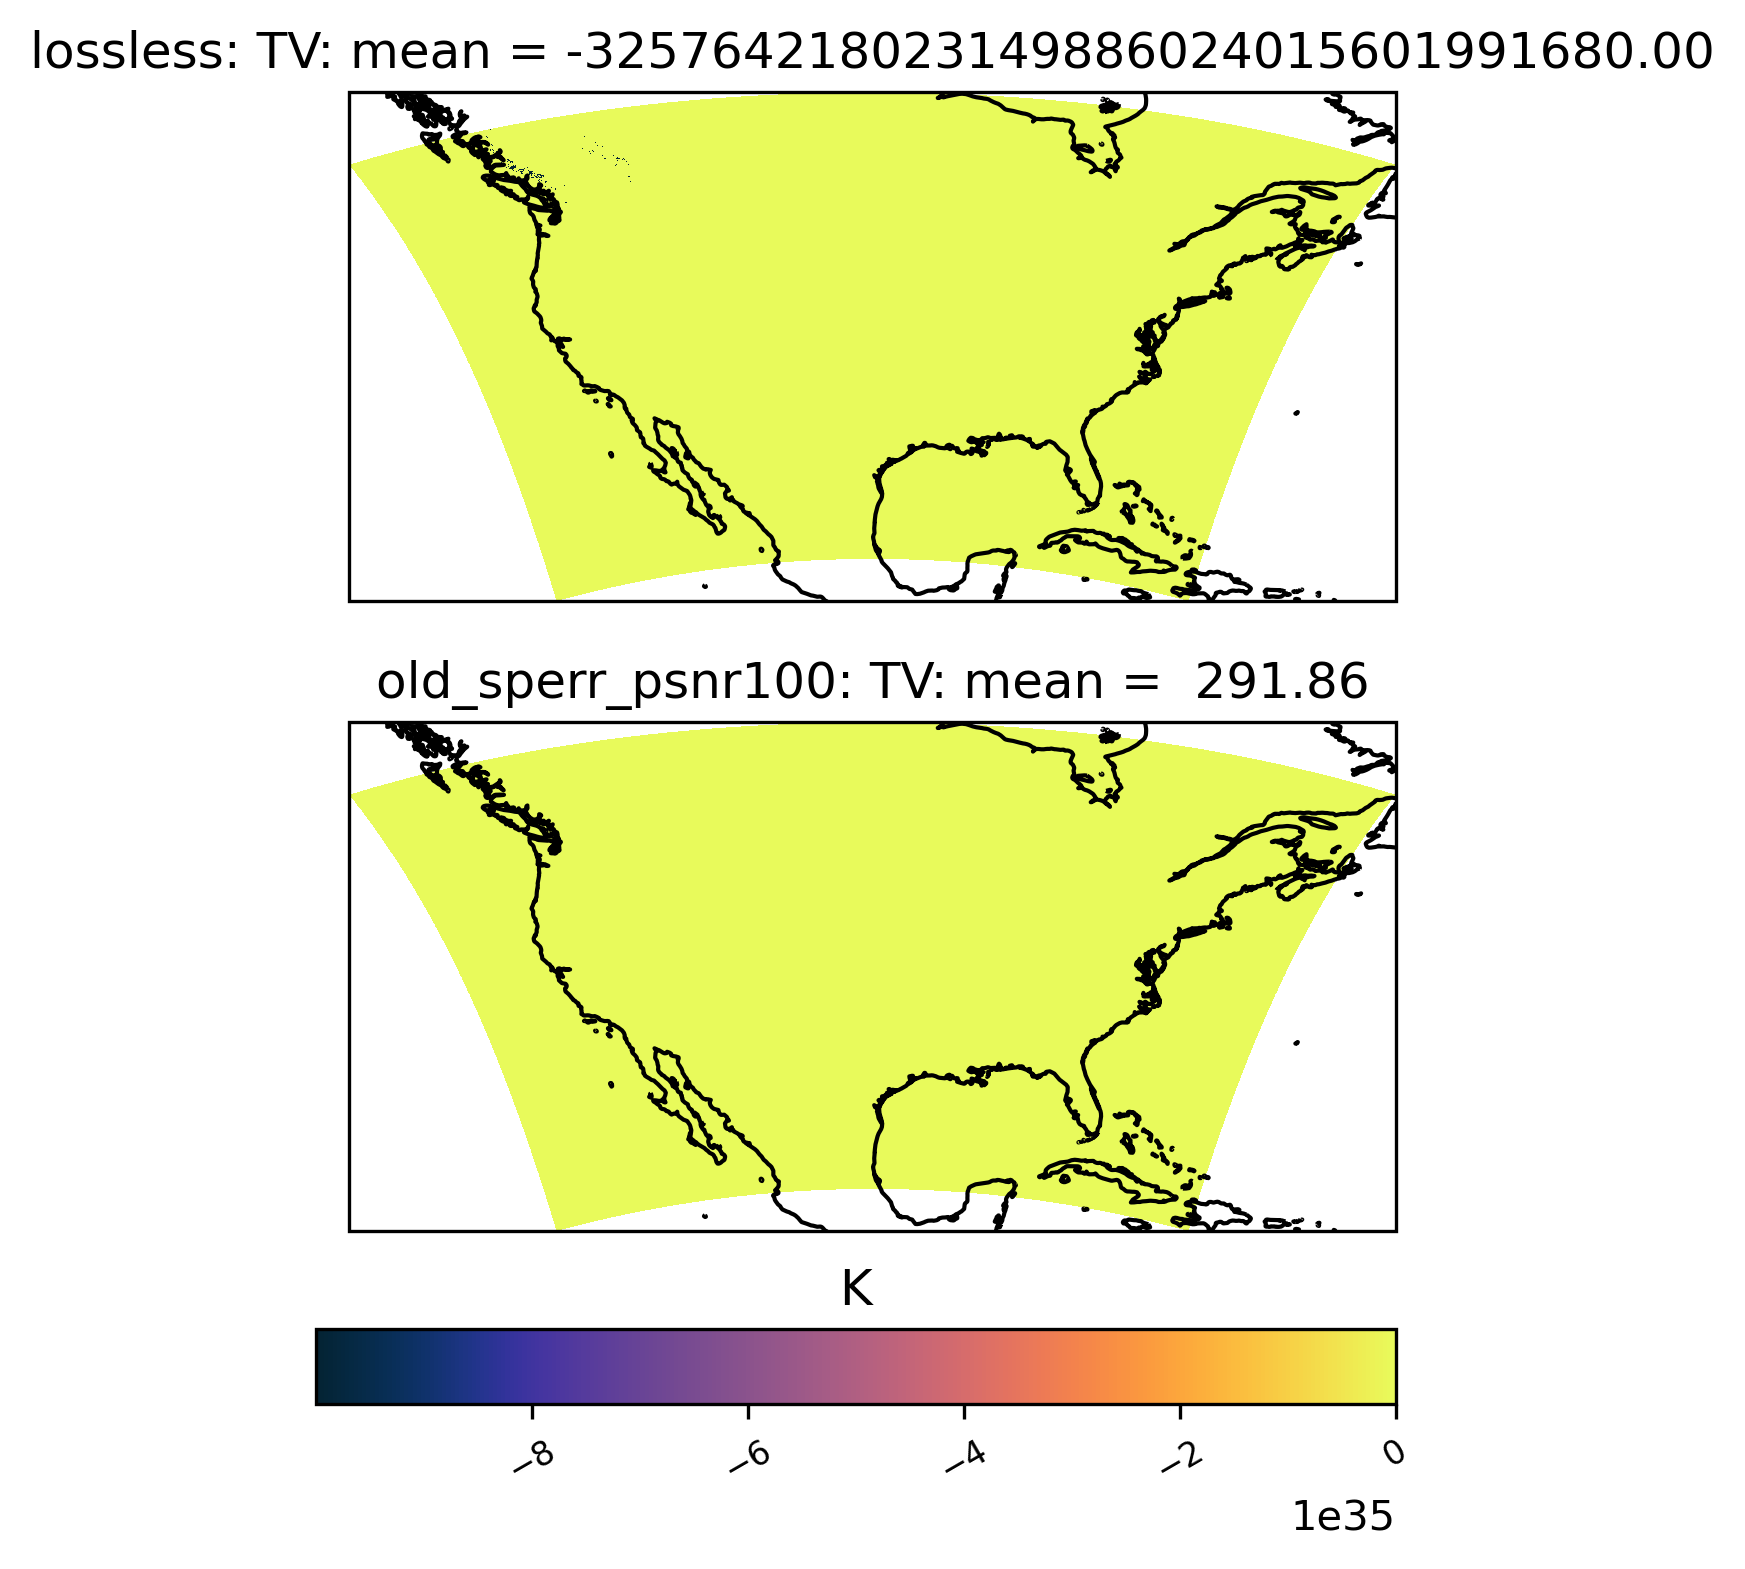

In [54]:
# plot mean TV field
ldcpy.plot(
    combine_col_2d,
    "TV",
    sets=["lossless", "old_sperr_psnr100"],
    calc="mean",
    plot_type="spatial",
    color="cmo.thermal",
    vert_plot=True,
)

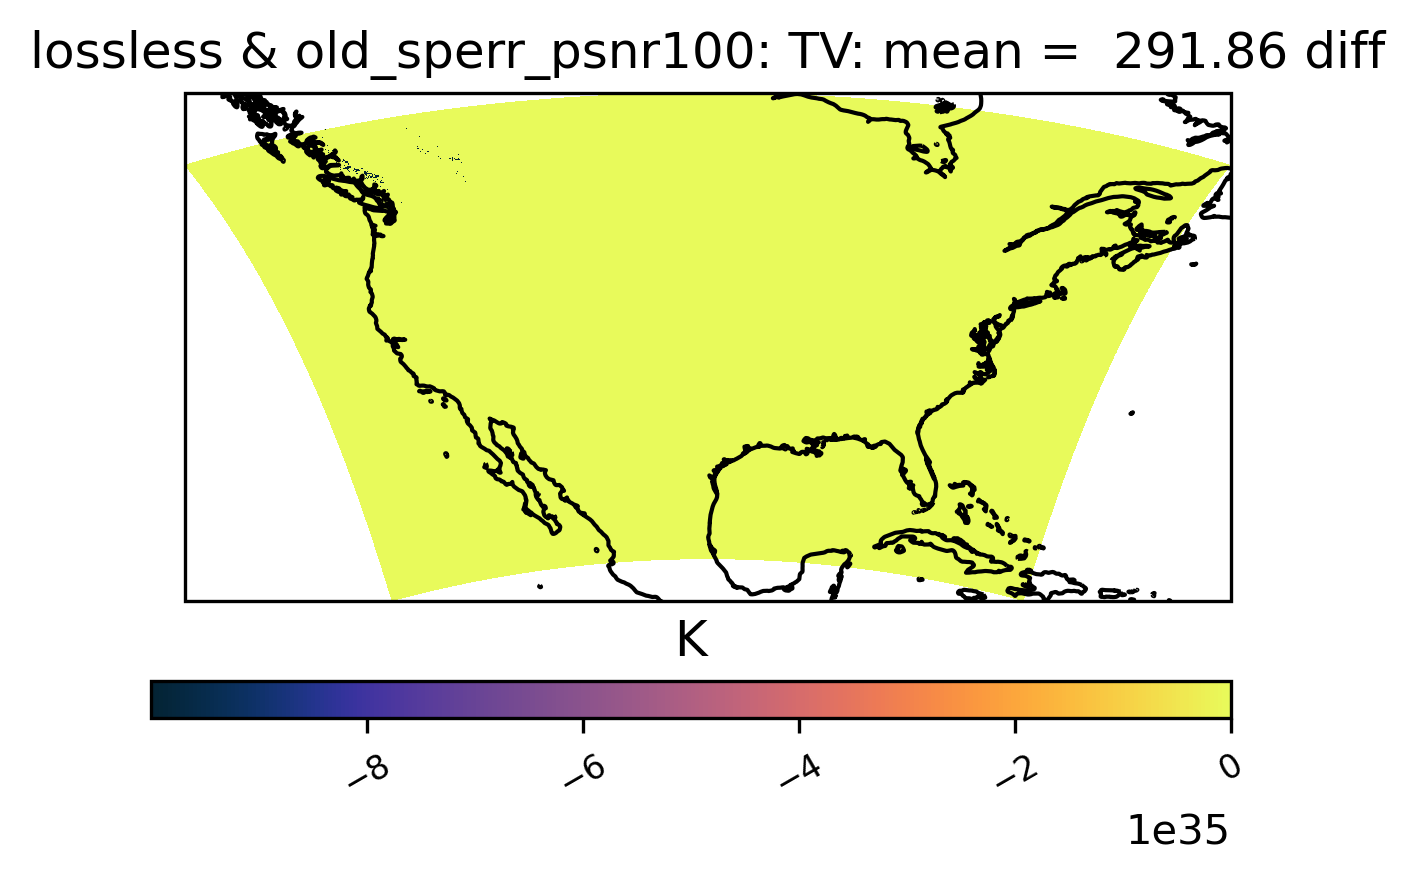

In [55]:
# Plot the differences for T2
# plot mean TV field
ldcpy.plot(
    combine_col_2d,
    "TV",
    sets=["lossless", "old_sperr_psnr100"],
    calc="mean",
    calc_type="diff",
    plot_type="spatial",
    color="cmo.thermal",
    vert_plot=True,
)

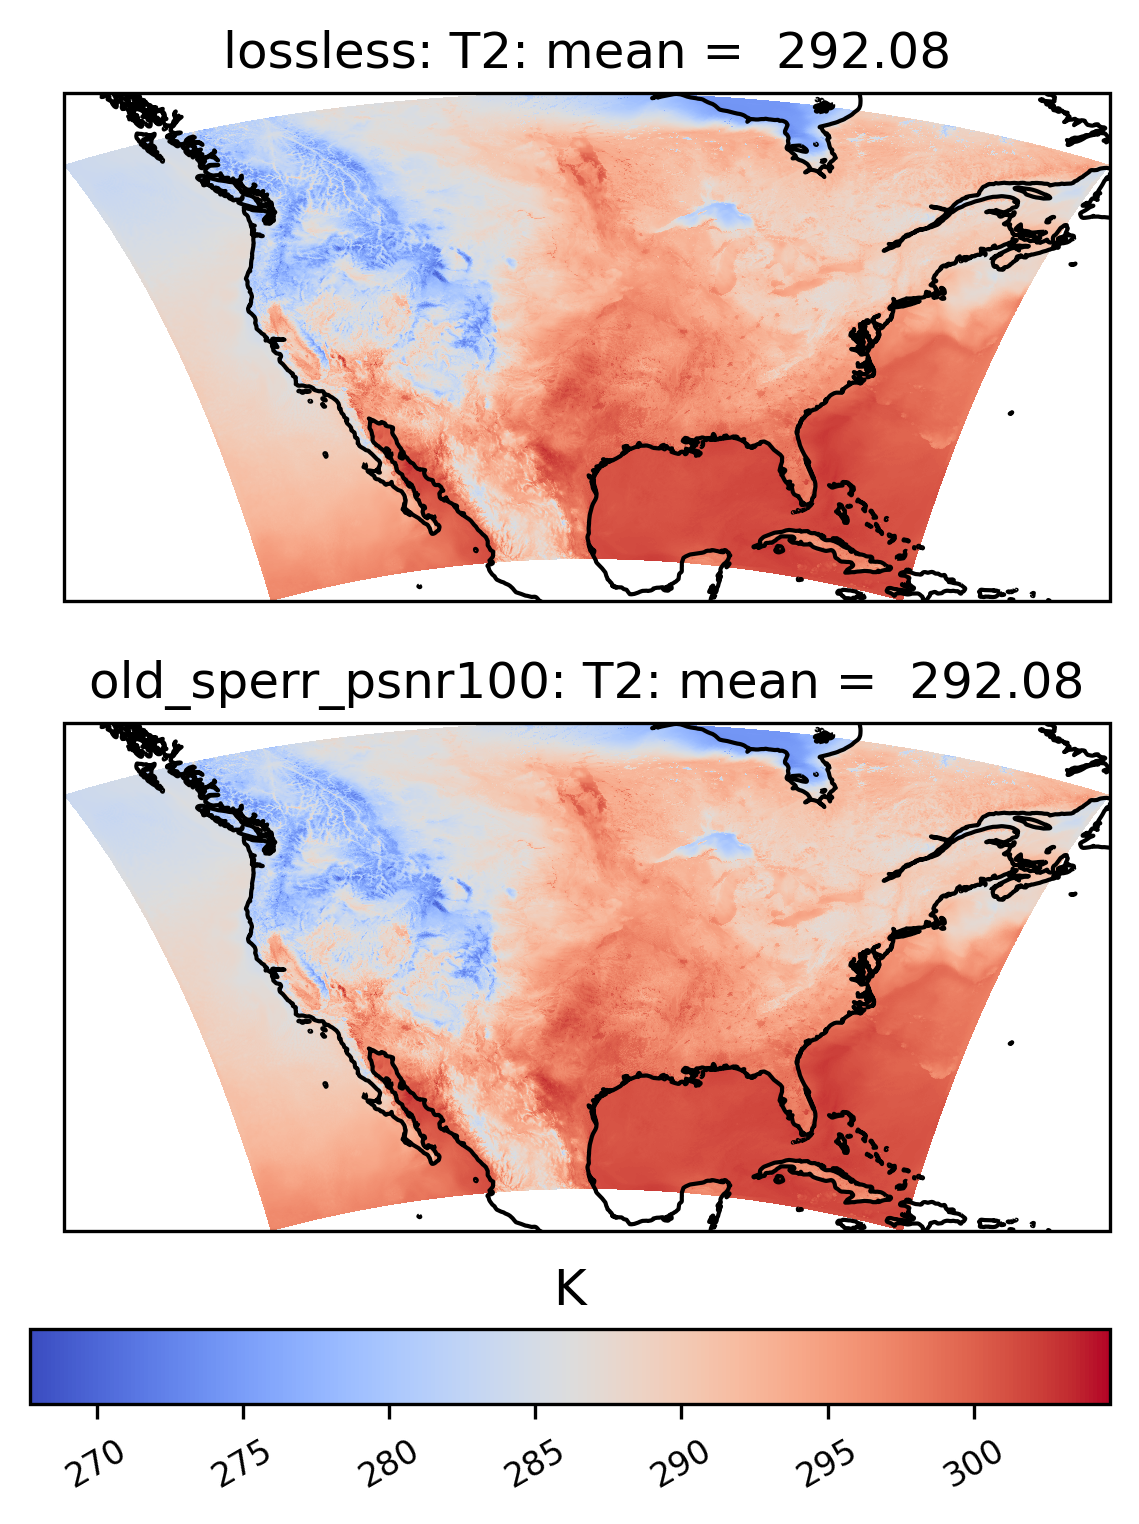

In [56]:
ldcpy.plot(
    combine_col_2d,
    "T2",
    sets=["lossless", "old_sperr_psnr100"],
    calc="mean",
    plot_type="spatial",
    vert_plot=True,
    # axes_symmetric=True
)

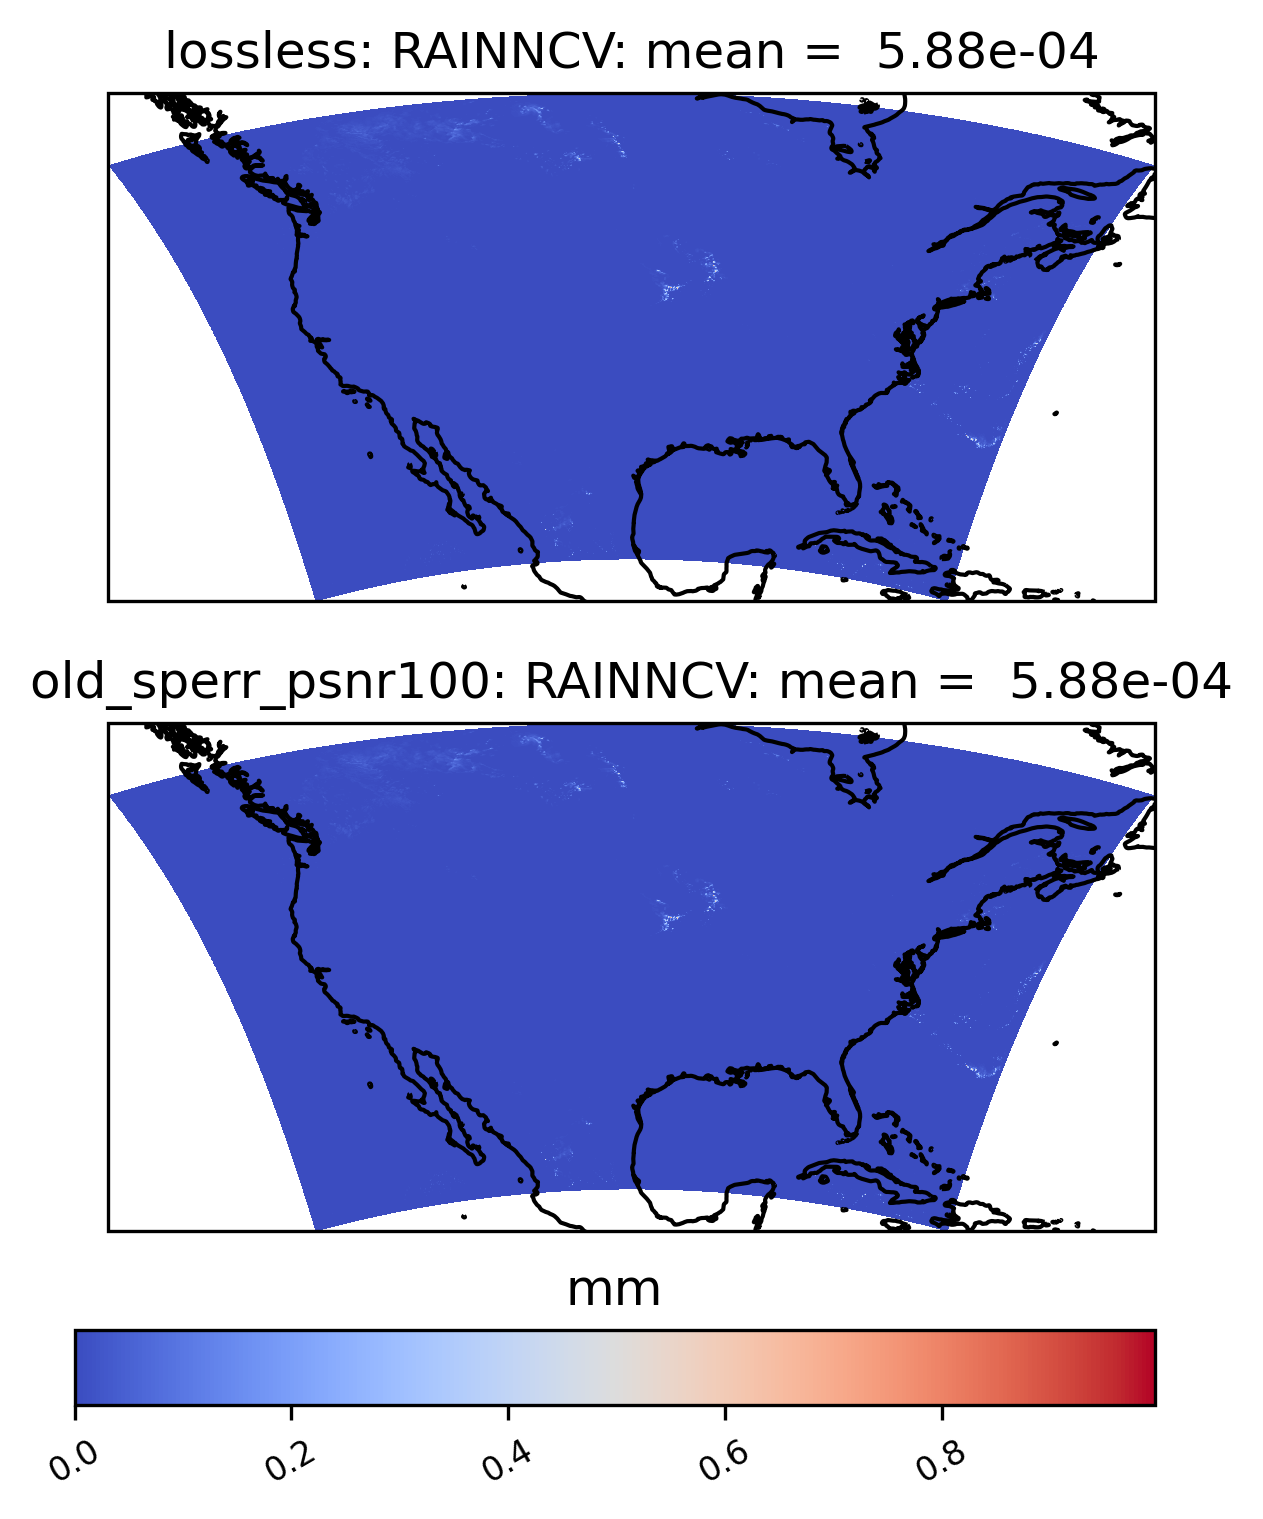

In [51]:
# do some plots for rain
ldcpy.plot(
    combine_col_2d,
    "RAINNCV",
    sets=["lossless", "old_sperr_psnr100"],
    calc="mean",
    plot_type="spatial",
    vert_plot=True,
    # axes_symmetric=True
)

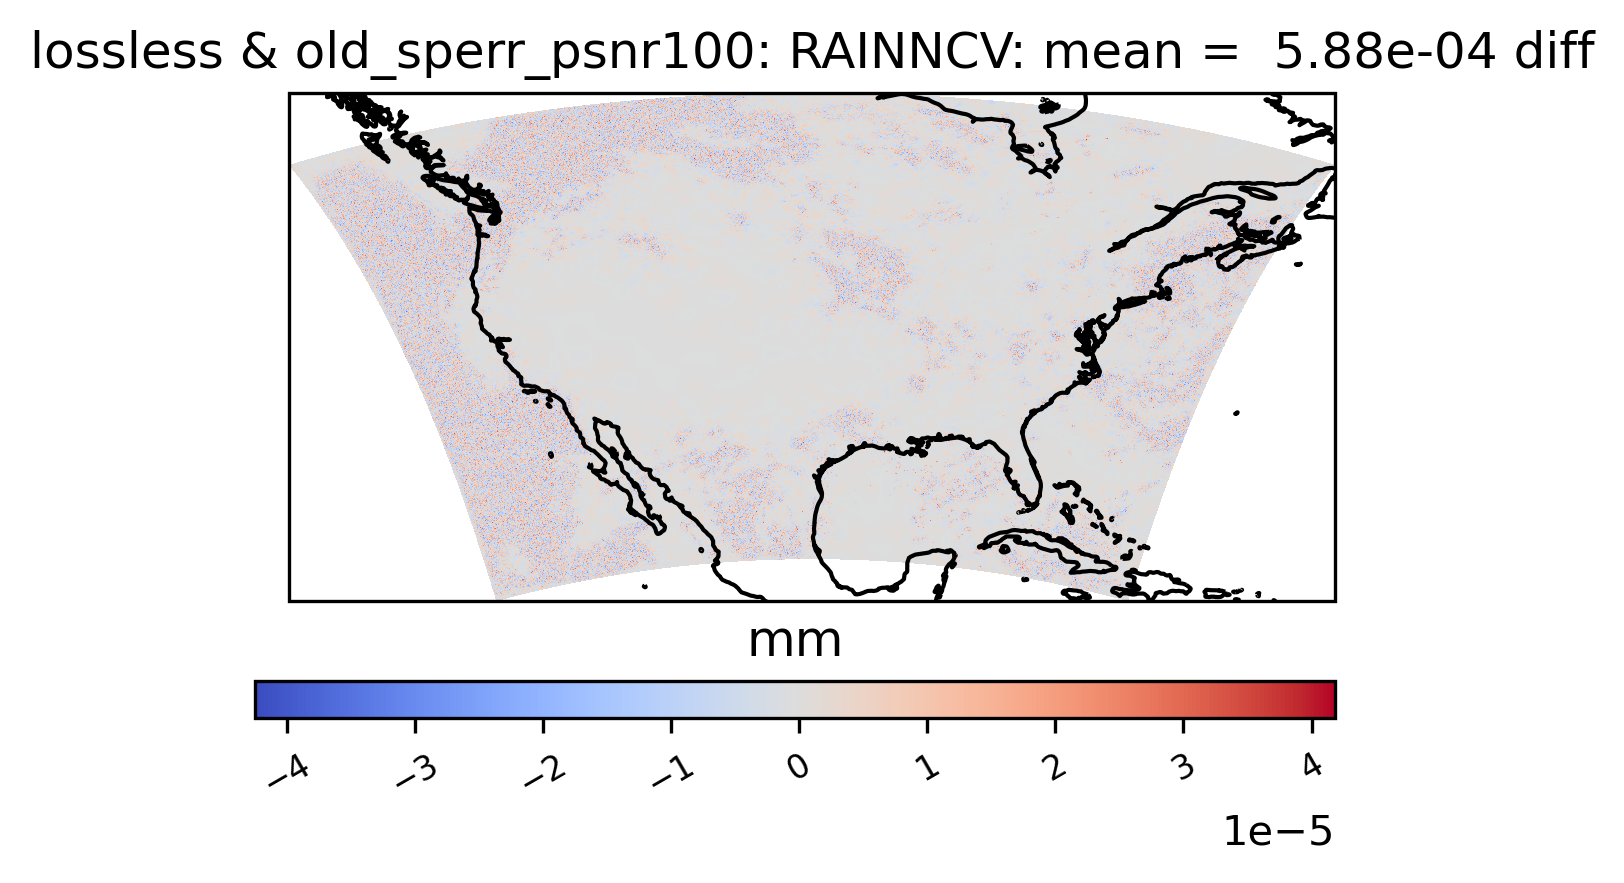

In [52]:
ldcpy.plot(
    combine_col_2d,
    "RAINNCV",
    sets=["lossless", "old_sperr_psnr100"],
    calc="mean",
    calc_type="diff",
    plot_type="spatial",
    vert_plot=True,
)

In [19]:
a = ds_orig_2d["LAI"].data
b = ds_old_sp_2d["LAI"].data

In [20]:
a

array([[[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 1.5454102, 1.3706055,
         1.5498047],
        [0.       , 0.       , 0.       , ..., 1.4189453, 1.4897461,
         1.4555664],
        [0.       , 0.       , 0.       , ..., 1.3452148, 1.3461914,
         1.2958984]]], dtype=float32)

In [21]:
b

array([[[ 1.3529618e-06,  1.3517576e-06,  1.3492081e-06, ...,
          3.4568369e-05,  2.6569262e-05,  2.0882087e-05],
        [ 1.3512207e-06,  1.3500753e-06,  1.3476504e-06, ...,
          1.6100834e-05,  1.9121833e-05,  1.9733399e-05],
        [ 1.3475631e-06,  1.3465410e-06,  1.3443783e-06, ...,
         -1.4763091e-05,  3.4236157e-06,  1.4336306e-05],
        ...,
        [-1.2564726e-07, -4.5232676e-07, -1.1110510e-06, ...,
          1.5454471e+00,  1.3706883e+00,  1.5498234e+00],
        [-1.3195624e-07, -4.5937401e-07, -1.1196003e-06, ...,
          1.4188721e+00,  1.4898427e+00,  1.4555433e+00],
        [-1.3526750e-07, -4.6304993e-07, -1.1240180e-06, ...,
          1.3452978e+00,  1.3462262e+00,  1.2959611e+00]]], dtype=float32)

In [30]:
o = ds_orig_2d["RAINNCV"].data
c = ds_old_sp_2d["RAINNCV"].data

In [36]:
c

array([[[ 2.8241636e-06,  2.7170120e-06,  2.5156094e-06, ...,
         -7.1430878e-07, -7.1942509e-07, -7.2196116e-07],
        [ 2.4832898e-06,  2.3633727e-06,  2.1434696e-06, ...,
         -6.9996003e-07, -7.0495804e-07, -7.0743772e-07],
        [ 1.8376486e-06,  1.7081405e-06,  1.4782937e-06, ...,
         -6.6988093e-07, -6.7462628e-07, -6.7698323e-07],
        ...,
        [-2.3299413e-06, -2.2660317e-06, -2.1353371e-06, ...,
         -4.1086284e-07, -3.9496283e-07, -3.9853552e-07],
        [-2.3313619e-06, -2.2675458e-06, -2.1370060e-06, ...,
         -4.3820904e-07, -4.2142270e-07, -4.2531977e-07],
        [-2.3316986e-06, -2.2679769e-06, -2.1376027e-06, ...,
         -4.5622534e-07, -4.3974538e-07, -4.4385089e-07]]], dtype=float32)

In [53]:
o

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)